In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

# import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [ ]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree

### Taken from Richard's "Reprod Figure 2"

In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def cef_estimate_mike_1(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    tree_idx = 0
    for tree in model:
        
        # get out of bag indices.       
        # Here's where we obtain unsampled indices.
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,X.shape[0]), sampled_indices)
        tree_idx = tree_idx + 1
        # Done with unsampled indices.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

### Generating data and prediction.

In [6]:
def generate_data(n, d, pi, mu = 1):
    
    means, Sigma, probs = _make_params(d, pi, mu = mu)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(k, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    return X, y

def _make_params(d, pi, mu = 1):
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    probs = [pi, 1 - pi]
    
    return means, Sigma, probs

## Class Prior Plots

In [8]:
def compute_mutual_info(d, pi, base = np.exp(1)):
    
    if d > 1:
        dim = 2
    else:
        dim = 1
 
    means, Sigma, probs = _make_params(dim, pi = pi)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    
    return I_XY, H_X, H_Y

In [9]:
def estimate_mi(X, y, label, est_H_Y, norm_factor):
    
    if label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return est_H_Y - np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return est_H_Y - cef_estimate_mike_1(np.array(X), y, 300, .32, depth = 30)
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1)) / norm_factor
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1)) / norm_factor
    else:
        raise ValueError("Unrecognized Label!")

In [10]:
def get_mutual_info_vs_pi(n, d, pis, num_trials, algos):
    
    def worker(t):
        X, y = generate_data(n, d, pi = elem)
        
        I_XY, H_X, H_Y = compute_mutual_info(d, elem)
        norm_factor = min(H_X, H_Y)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label'], est_H_Y, norm_factor))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(pis), num_trials))
    for i, elem in enumerate(pis):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(pis, open('pis.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_pi_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [26]:
# Takes 'd'.
def plot_mutual_info_by_pi(algos, d, ax):
    pis = pickle.load(open('pis.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_pi_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(pis,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

    truth = pickle.load(open('truth_d_%d.pkl' % d, 'rb'))
    ax.plot(pis, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Class Prior")
    ax.set_xlim(left = np.amin(pis) - 0.05)
    ax.set_xlim(right = np.amax(pis) + 0.05)
    ax.set_ylabel("Estimated Normalized MI")

In [12]:
# Compute true values for normalized mutual info.
def compute_truth(d, pis):
    truth = np.zeros(len(pis))
    for i in range(len(pis)):
        I_XY, H_X, H_Y = compute_mutual_info(d, pis[i])
        truth[i] = I_XY / min(H_X, H_Y)
        
    pickle.dump(truth, open('truth_d_%d.pkl' % d, 'wb'))

In [13]:
# Data.
n1 = 6000
n2 = 10000
pis = [0.05 * i for i in range(1, 20)]
num_trials = 20
d1 = 1
d2 = 20

# Fake params
# n1 = 200
# n2 = 250
# pis = [0.05 * i for i in range(1, 4)]
# num_trials = 3
# d1 = 1
# d2 = 2


# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [14]:
compute_truth(d1, pis)
compute_truth(d2, pis)

In [ ]:
get_mutual_info_vs_pi(n1, d1, pis, num_trials, algos)

In [15]:
get_mutual_info_vs_pi(n2, d2, pis, num_trials, algos)

array([[[0.09994326, 0.14897069, 0.06876067],
        [0.06694079, 0.05135577, 0.20152298],
        [0.16045379, 0.24462219, 0.14667897]],

       [[0.54346136, 0.26237086, 0.09651592],
        [0.17690116, 0.17266369, 0.50530127],
        [0.28517019, 0.49037257, 0.32857248]],

       [[0.6204033 , 0.60393947, 0.38679022],
        [0.36071417, 0.38543458, 0.60868155],
        [0.35257673, 0.52501987, 0.35046045]],

       [[0.086302  , 0.06367263, 0.05841925],
        [0.06458681, 0.08063123, 0.12337853],
        [0.12822507, 0.14556674, 0.08882098]]])

In [41]:
def plot_fig3b(algos, d1, d2):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(1, 2, figsize = (19,10))

    plot_mutual_info_by_pi(algos, d1, axes[0])
    plot_mutual_info_by_pi(algos, d2, axes[1])
        
    axes[0].set_title('d = %d' % d1)
    axes[1].set_title('d = %d' % d2)
    axes[1].legend(loc = "upper right")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig3b.pdf")
    plt.show()

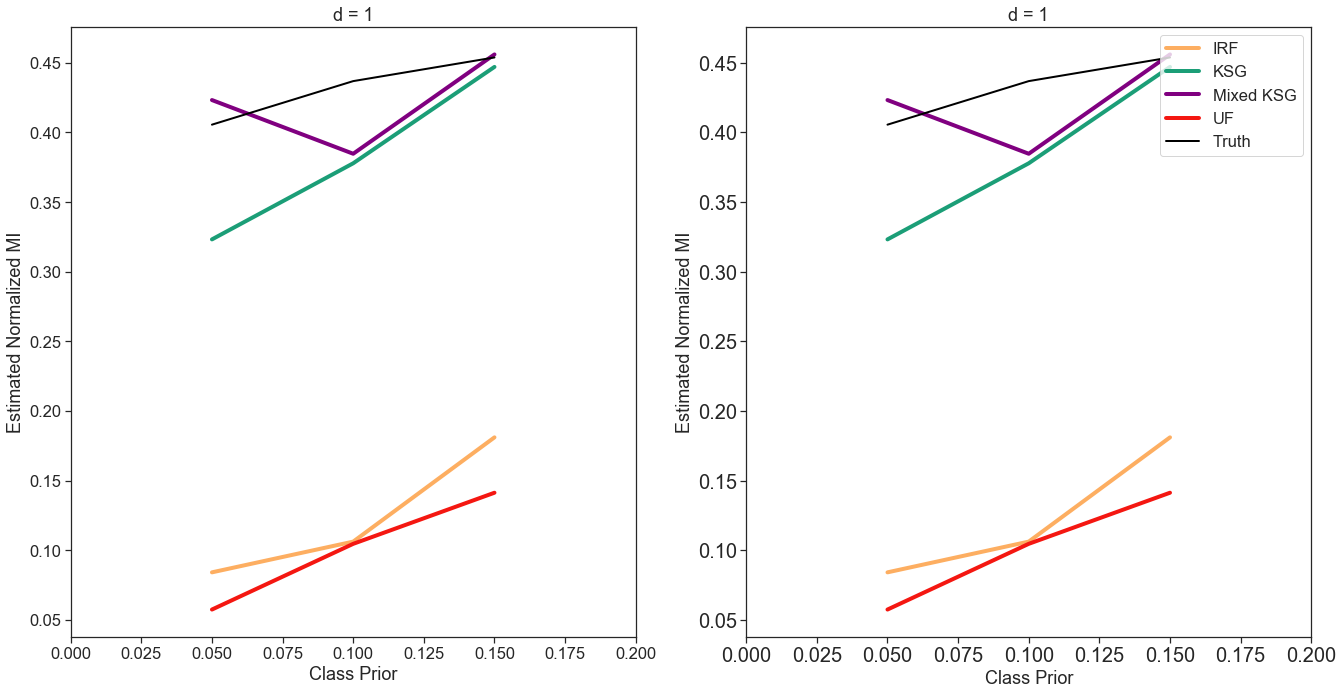

In [42]:
# Run settings cell first.
plot_fig3b(algos, d1, d1)